In [1]:
import h5py
import numpy as np
import glob, os, re, sys
import pickle

import astro_helper as ah
from MergertreesProps import MergertreeProps

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import rc
plt.style.use('bmh')
rc('font',**{'family':'DejaVu Sans','sans-serif':['Helvetica']})

# analyze cloud evolution in terms of Monte Carlo trajectories

In [2]:
# MergertreeProps instance
mergertree_name = 'merger_tree_601-799.pkl'
props = MergertreeProps(mergertree_name, num_mc_iter=1, num_mc_workers=1)

In [3]:
print(props.get_timestep())
print(props.get_width()/ah.kpc_to_cm)

0.0010000753722734898
15.166492714294376


In [4]:
props.cut_wcs(time_cut=True, radius_cut=True, time_rsln_cut=True)

In [5]:
props.save_cloud_evol_mc()

thread 0 started


TypeError: 'int' object is not iterable

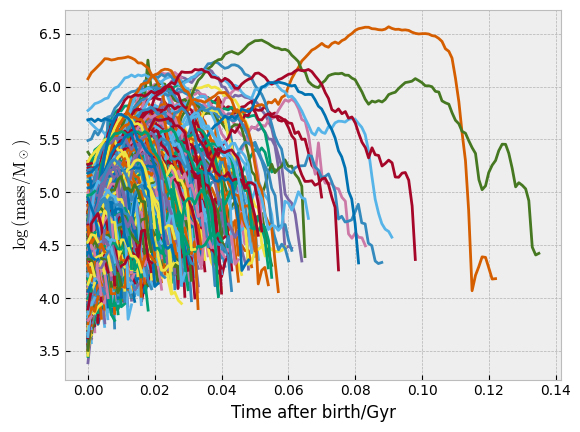

In [32]:
# show the mass evolution of all the clouds
for times, masses in zip(cloud_evol_wcs['time'], cloud_evol_wcs['mass']):
    plt.plot(times-np.min(times), np.log10(np.array(masses)/ah.Msol_to_g))
plt.xlabel('Time after birth/Gyr')
plt.ylabel(r'$\log{({\rm mass}/{\rm M}_\odot)}$')
plt.show()

In [33]:
# we can get a clearer picture if we just show the average time evolution in bins of the maximum/peak mass
logmass_bin_edges = np.linspace(np.log10(np.min(ah.flatten_list(cloud_evol_wcs['mass']))/ah.Msol_to_g),
                                np.log10(np.max(ah.flatten_list(cloud_evol_wcs['mass']))/ah.Msol_to_g),
                                8)
logmaxmasses = [np.log10(np.max(masses)/ah.Msol_to_g) for masses in cloud_evol_wcs['mass']]
maxmass_idcs = np.digitize(logmaxmasses, logmass_bin_edges)-1

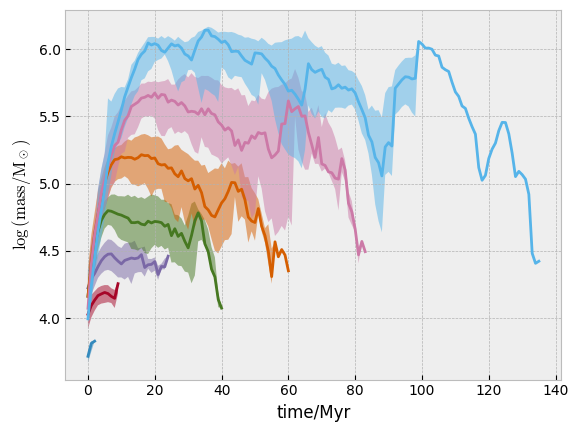

In [41]:
# median evolving masses
for i in range(np.max(maxmass_idcs)):
    masslists_bin = [mass for mass, idx in zip(cloud_evol_wcs['mass'], maxmass_idcs) if idx==i]
    maxlen_masslists_bin = np.max([len(elem) for elem in masslists_bin])
    medmasses_bin = [np.median([masses[j] for masses in masslists_bin if j<len(masses)]) for j in range(maxlen_masslists_bin)]
    q1masses_bin = [np.quantile([masses[j] for masses in masslists_bin if j<len(masses)], 0.25) for j in range(maxlen_masslists_bin)]
    q4masses_bin = [np.quantile([masses[j] for masses in masslists_bin if j<len(masses)], 0.75) for j in range(maxlen_masslists_bin)]

    plt.plot(range(maxlen_masslists_bin), np.log10(np.array(medmasses_bin)/ah.Msol_to_g))
    plt.fill_between(range(maxlen_masslists_bin),
                     np.log10(np.array(q1masses_bin)/ah.Msol_to_g),
                     y2=np.log10(np.array(q4masses_bin)/ah.Msol_to_g), alpha=0.5)
plt.xlabel('time/Myr')
plt.ylabel(r'$\log{({\rm mass}/{\rm M}_\odot)}$')
plt.show()

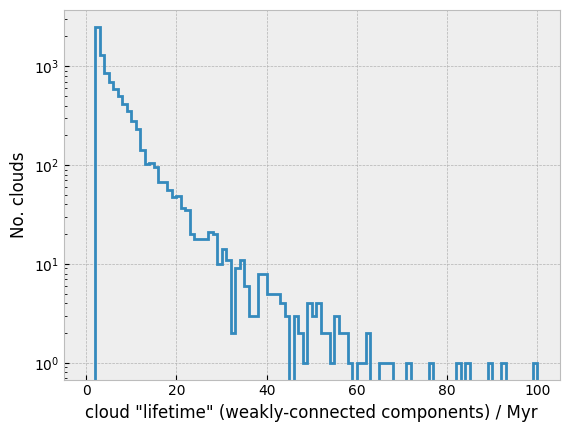

In [42]:
# lifetimes
cloud_evol_lifetimes = [len(elem) for elem in cloud_evol_wcs['mass']]

plt.hist(np.array(cloud_evol_lifetimes), bins=np.linspace(0., 100, 101), log=True, histtype='step', lw=2)
plt.xlabel('cloud "lifetime" (weakly-connected components) / Myr')
plt.ylabel('No. clouds')
plt.show()

# is there a difference for the unpruned graph? I.e. does pruning make a noticeable/macro difference?

In [43]:
props_unpruned = MergertreeProps(mergertree_name)
cloud_evol_wcs_unpruned = props_unpruned.get_cloud_evol_wcs(['mass', 'starformrate'])

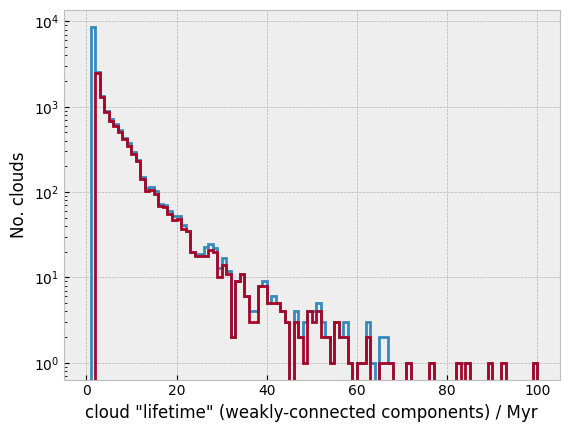

In [45]:
# lifetimes
cloud_evol_lifetimes_unpruned = [len(elem) for elem in cloud_evol_wcs_unpruned['mass']]

plt.hist(np.array(cloud_evol_lifetimes_unpruned), bins=np.linspace(0., 100, 101), log=True, histtype='step', lw=2)
plt.hist(np.array(cloud_evol_lifetimes), bins=np.linspace(0., 100, 101), log=True, histtype='step', lw=2)
plt.xlabel('cloud "lifetime" (weakly-connected components) / Myr')
plt.ylabel('No. clouds')
plt.show()

### so yes, we see that the pruning removes thousands of incomplete cloud evolution segments/artefacts that would otherwise be counted as short cloud lifetimes - it's worth doing